# Build and Train Decision Trees for Classification Problems
## Purpose
In this example we will demonstrate how to:
   - Build a coreset tree for classification decision trees based on a real-world multiclass dataset.
   - Perform coreset tree vs. entire train dataset vs. random selection comparison as follows:
      - Retrieve the coreset from the coreset tree using get_coreset, and train an xgboost's XGBClassifier model on it.
      - Build an XGBClassifier model on the entire train dataset.
      - Build an XGBClassifier model on a randomly-sampled train dataset, where the sample size exactly matches coreset size.
      - Build an XGBClassifier model on a randomly-sampled train dataset, where the sample size is large-enough to strive to match the quality of using the coreset from the coreset tree.
      - Compare the quality of all four models built.
   - Repeat the comparison sets above, using two additional flavours:
      - Utilizing xgboost's native DMatrix interface (instead of the XGBClassifier sklearn wrapper).
      - Calling our library's service object's direct fit function (employing XGBClassifier behind the scenes).
   - Employ coreset tree's utility functions for saving, loading and plotting the coreset tree.

For the example dataset, we will be using the PokerHand OpenML dataset (https://www.openml.org/search?type=data&status=active&id=155).
The data will be split into 'train' and 'test' portions using sklearn's train/test split (80% for the train portion, 20% for the test).
The 'train' portion will consist of roughly 663K samples, and the 'test' portion will have around 166K samples.
Our comparisons will utilize the balanced accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) as the evaluation metric.


In [1]:
import os
import warnings
from time import time

import numpy as np
import pandas as pd
import xgboost as xgb
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier

from dataheroes import CoresetTreeServiceDTC

## 1. Prepare the dataset & the testing environment

In [2]:
# Load PokerHand dataset as X, y (data, target) from openml.
X, y = fetch_openml("pokerhand", return_X_y=True)

# One-hot encode all columns (not only the categorical ones).
# We may, in fact, encode only categorical columns - but we do the inclusive encoding
# here, since even the numeric features have small number of distinct values.
one_hot = OneHotEncoder(sparse=False)
one_hot.fit(X)
X = one_hot.transform(X)
X = X.astype(np.int8)

# Label-Encode the target. We do so because, further down the road, we will use XGBoost for
# modeling, which requires consecutive integer labels starting from 0.
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)

# Merge 3 class labels into a single label, to make the data-set have only 5 targets.
# (Otherwise, the smaller class is made up of only 2 samples, and the last but one - with only 11.)
y[y > 3] = 4

# Apply standard scaling on the X.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split to train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remember the number of classes (5) required for the upcoming training code.
num_classes = len(np.unique(y_train))
print(f"#classes={num_classes}, train size={len(X_train):,}, test size={len(X_test):,}")

# Define the number of estimators for xgboost.
# Even if we use the defaults, while 100 is the default for XGBClassifier, we do emphasize this value
# in a separate variable, for the sake of the comparison to the DMatrix approach - the default of
# which is different (10) - henceforth necessitating synchronization between the two approaches.
# The higher the number of estimators, the better the results will be (but the longer the time will take).
n_estimators = 100

# Set the tree access level which we will be working with (default is 0=root node).
tree_query_level = 1

# Remember the number of samples for the full dataset.
n_samples_full = len(y_train)

# Define the number of samples for the comparison flavour in which a randomly-selected dataset is striving to resemble coreset dataset's quality.
n_samples_rand_large = int(n_samples_full * 0.3)

# Define method for summarizing every flavour's experimental results in one neat table.
def produce_results(experiment_group : str,
                    n_samp_full : int, n_samp_rand_large : int, n_samp_coreset : int,
                    full_score : float, rand_large_score : float, rand_csize_score : float, coreset_score : float,
                    full_secs : float, rand_large_secs : float, rand_csize_secs : float, coreset_secs : float):

    df = pd.DataFrame(data={
        ' ': ['Full dataset', 'Random bigger-sized sample', 'Random smaller-sized sample', 'Coreset'],
        'Training dataset size': [n_samp_full, n_samp_rand_large, n_samp_coreset, n_samp_coreset],
        '% of full dataset': [n_samp_full / n_samp_full, n_samp_rand_large / n_samp_full, n_samp_coreset / n_samp_full, n_samp_coreset / n_samp_full],
        'Balanced accuracy score': [full_score, rand_large_score, rand_csize_score, coreset_score],
        'Training time (sec)': [full_secs, rand_large_secs, rand_csize_secs, coreset_secs],
    })
    last_row = pd.IndexSlice[df.index[-1], :]
    styles = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "120%"), ("font-weight", "bold")])]
    s  = df.style \
        .set_properties(subset=[' '],**{'text-align':'left'}) \
        .set_properties(subset=['Training dataset size','% of full dataset','Balanced accuracy score','Training time (sec)'],**{'text-align':'right'}) \
        .set_properties(subset=last_row, **{'color':'green', 'font-weight':'bold'}) \
        .set_caption(f"{experiment_group} Results") \
        .format({
        'Training dataset size': '{:,}',
        '% of full dataset': '{:.2%}',
        'Balanced accuracy score': '{:.4f}',
        'Training time (sec)': '{:.2f}'}) \
        .hide(axis='index') \
        .set_table_styles(styles)
    return s

#classes=5, train size=663,360, test size=165,841


## 2. Build the coreset tree
Create a new service object and run `build` directly on the X, y train data.
We pass `chunk_size` and `coreset_size` instead of passing `n_instances` to initialize the coreset tree.

In [3]:
t = time()
service_obj = CoresetTreeServiceDTC(optimized_for='training',
                                    chunk_size=40_000,
                                    coreset_size=15_000)
service_obj.build(X_train, y_train)
cset_build_secs = time() - t

## 3. Tree-based coreset performance comparison: XGBClassifier (sklearn XGBoost wrapper) modeling approach

### 3.1 Get a coreset from the tree & train a model based on it

In [4]:
t = time()
# Get the coreset from the tree.
coreset = service_obj.get_coreset(level=tree_query_level)
indices_coreset_, X_coreset, y_coreset = coreset['data']
w_coreset = coreset['w']

# Train an XGBoost model on the coreset.
# For multiclass classification problems, the correct objective would be 'multi:softmax'.
xgbclassifier_coreset_model = XGBClassifier(objective='multi:softmax',
                                            num_class=num_classes,
                                            n_estimators=n_estimators)
xgbclassifier_coreset_model.fit(X_coreset, y_coreset, sample_weight=w_coreset)
n_samples_coreset = len(y_coreset)
cset_train_secs = time() - t
xgbclassifier_coreset_secs = cset_train_secs + cset_build_secs

### 3.2. Train a model on the entire dataset (for comparison)
We use the same (entire) training part of the dataset that was used for building the coreset tree.

In [5]:
t = time()
# Train an XGBoost model on the entire data-set.
xgbclassifier_full_model = XGBClassifier(objective='multi:softmax',
                                         num_class=num_classes,
                                         n_estimators=n_estimators)
xgbclassifier_full_model.fit(X_train, y_train)
xgbclassifier_full_secs = time() - t

### 3.3. Train models on samples selected randomly from the training set

### 3.3.1. Produce a randomly-selected sample matching the coreset's size

In [6]:
t = time()
# Train an XGBoost model on the random data-set -
# (1) Create the model, (2) randomly sample the exact size as the coreset size, and (3) train the model.
xgbclassifier_rand_csize_model = XGBClassifier(objective='multi:softmax',
                                               num_class=num_classes,
                                               n_estimators=n_estimators)
xgbclassifier_rand_csize_idxs = np.random.choice(n_samples_full, n_samples_coreset, replace=False)
xgbclassifier_rand_csize_model.fit(X_train[xgbclassifier_rand_csize_idxs, :], y_train[xgbclassifier_rand_csize_idxs])
xgbclassifier_rand_csize_secs = time() - t

### 3.3.2. Produce a randomly-selected sample striving to match coreset's quality

In [7]:
t = time()
# Train an XGBoost model on the random data-set -
# (1) Create the model, (2) randomly sample size larger than the coreset size, and (3) train the model.
xgbclassifier_rand_large_model = XGBClassifier(objective='multi:softmax',
                                               num_class=num_classes,
                                               n_estimators=n_estimators)
xgbclassifier_rand_large_idxs = np.random.choice(n_samples_full, n_samples_rand_large, replace=False)
xgbclassifier_rand_large_model.fit(X_train[xgbclassifier_rand_large_idxs, :], y_train[xgbclassifier_rand_large_idxs])
xgbclassifier_rand_large_secs = time() - t

### 3.4. Compare models quality
Test coreset, random samples and full models on a test dataset, and compare their evaluation scores.

In [8]:
# Evaluate models.
xgbclassifier_full_score = balanced_accuracy_score(y_test, xgbclassifier_full_model.predict(X_test))
xgbclassifier_rand_large_score = balanced_accuracy_score(y_test, xgbclassifier_rand_large_model.predict(X_test))
xgbclassifier_rand_csize_score = balanced_accuracy_score(y_test, xgbclassifier_rand_csize_model.predict(X_test))
xgbclassifier_coreset_score = balanced_accuracy_score(y_test, xgbclassifier_coreset_model.predict(X_test))
produce_results("XGBClassifier",
                n_samples_full, n_samples_rand_large, n_samples_coreset,
                xgbclassifier_full_score, xgbclassifier_rand_large_score, xgbclassifier_rand_csize_score, xgbclassifier_coreset_score,
                xgbclassifier_full_secs, xgbclassifier_rand_large_secs, xgbclassifier_rand_csize_secs, xgbclassifier_coreset_secs)

,Training dataset size,% of full dataset,Balanced accuracy score,Training time (sec)
Full dataset,"663,360",100.00%,0.9723,117.09
Random bigger-sized sample,"199,008",30.00%,0.9574,37.83
Random smaller-sized sample,"21,717",3.27%,0.8239,4.06
Coreset,"21,717",3.27%,0.9751,22.00


## 4. Tree-based coreset performance comparison: DMatrix (XGBoost native) modeling approach

### 4.1 Get a coreset from the tree & train a DMatrix model based on it

In [9]:
t = time()
# Get the coreset from the tree.
coreset = service_obj.get_coreset(level=tree_query_level)
indices_coreset_, X_coreset, y_coreset = coreset['data']
w_coreset = coreset['w']

# Define XGBoost parameters to be used in all native DMatrix approaches.
dmatrix_params = {
    'objective': 'multi:softmax',
    'num_class': num_classes,
}

# Train on a coreset using DMatrix approach.
dmatrix_coreset_train = xgb.DMatrix(X_coreset, label=y_coreset, weight=w_coreset)
dmatrix_coreset_model = xgb.train(dmatrix_params, dmatrix_coreset_train, num_boost_round=n_estimators)
cset_train_secs = time() - t
dmatrix_coreset_secs = cset_train_secs + cset_build_secs

### 4.2. Train a model on the entire dataset (for comparison)
We use the same (entire) training part of the dataset that was used for building the coreset tree.

In [10]:
t = time()
# Train an XGBoost model on the full data-set using DMatrix approach.
dmatrix_full_train = xgb.DMatrix(X_train, label=y_train)
dmatrix_full_model = xgb.train(dmatrix_params, dmatrix_full_train, num_boost_round=n_estimators)
dmatrix_full_secs = time() - t

## 4.3. Train models on samples selected randomly from the training set

### 4.3.1. Produce a randomly-selected sample matching the coreset's size

In [11]:
t = time()
# Train on a coreset using DMatrix approach on the random data-set -
# (1) Create the model, (2) randomly sample the exact size as the coreset size, and (3) train the model.
dmatrix_rand_csize_idxs = np.random.choice(n_samples_full, n_samples_coreset, replace=False)
dmatrix_rand_csize_train = xgb.DMatrix(X_train[dmatrix_rand_csize_idxs, :], label=y_train[dmatrix_rand_csize_idxs])
dmatrix_rand_csize_model = xgb.train(dmatrix_params, dmatrix_rand_csize_train, num_boost_round=n_estimators)
dmatrix_rand_csize_secs = time() - t

### 4.3.2. Produce a randomly-selected sample striving to match coreset's quality

In [12]:
t = time()
# Train on a random data-set using DMatrix approach -
# (1) Create the model, (2) randomly sample size larger than the coreset size, and (3) train the model.
dmatrix_rand_large_idxs = np.random.choice(n_samples_full, n_samples_rand_large, replace=False)
dmatrix_rand_large_train = xgb.DMatrix(X_train[dmatrix_rand_large_idxs, :], label=y_train[dmatrix_rand_large_idxs])
dmatrix_rand_large_model = xgb.train(dmatrix_params, dmatrix_rand_large_train, num_boost_round=n_estimators)
dmatrix_rand_large_secs = time() - t

### 4.4. Compare models quality
Test coreset, random samples and full models on a test dataset, and compare their evaluation scores.

In [13]:
# Evaluate models.
dmatrix_test = xgb.DMatrix(X_test)
dmatrix_full_score = balanced_accuracy_score(y_test, dmatrix_full_model.predict(dmatrix_test))
dmatrix_rand_large_score = balanced_accuracy_score(y_test, dmatrix_rand_large_model.predict(dmatrix_test))
dmatrix_rand_csize_score = balanced_accuracy_score(y_test, dmatrix_rand_csize_model.predict(dmatrix_test))
dmatrix_coreset_score = balanced_accuracy_score(y_test, dmatrix_coreset_model.predict(dmatrix_test))
produce_results("DMatrix",
                n_samples_full, n_samples_rand_large, n_samples_coreset,
                dmatrix_full_score, dmatrix_rand_large_score, dmatrix_rand_csize_score, dmatrix_coreset_score,
                dmatrix_full_secs, dmatrix_rand_large_secs, dmatrix_rand_csize_secs, dmatrix_coreset_secs)

,Training dataset size,% of full dataset,Balanced accuracy score,Training time (sec)
Full dataset,"663,360",100.00%,0.9723,136.61
Random bigger-sized sample,"199,008",30.00%,0.9605,40.02
Random smaller-sized sample,"21,717",3.27%,0.8303,4.35
Coreset,"21,717",3.27%,0.9751,22.71


## 5. Tree-based coreset performance comparison: coreset tree's default fit modeling approach
Behind the scenes, the default modeling approach is implemented using XGBoostClassifier (in case xgboost library is installed) - or, using a fallback approach (usually, one of sklearn's ensemble classifiers) - in case the library is missing.

### 5.1 Train a model directly on the coreset tree service object

In [14]:
t = time()
# Ignore xgboost's warning about the requirement to pass the 'sample_weight' as a keyword arg and not as a positional arg.
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Please note the direct usage of "service_obj.fit()".
# Provide the same parameters to the fit method as you'd provide for the model generation and for tree access (required tree level).
service_obj.fit(level=tree_query_level,
                objective='multi:softmax',
                num_class=num_classes,
                n_estimators=n_estimators)
service_obj_n_samples_coreset = len(service_obj.get_coreset(level=tree_query_level)['w'])
cset_train_secs = time() - t
service_obj_coreset_secs = cset_train_secs + cset_build_secs

### 5.2. Train a model on the entire dataset (for comparison)
We use the same (entire) training part of the dataset that was used for building the coreset tree.
(Please note that for the sake of time saving, we reuse the same exact model generated in the step 3.2. above.)

In [15]:
# Just assign the same model and execution time, and do not call `fit`, since the model has already been trained.
service_obj_full_model = xgbclassifier_full_model
service_obj_full_secs = xgbclassifier_full_secs

## 5.3. Train models on samples selected randomly from the training set

### 5.3.1. Produce a randomly-selected sample matching the coreset's size
(Please note that while we could've reused a model generated in step 3.3.1. above, the coreset returned by the service object may have a different size - and because of that, we will train a new model matching the exact size of the service_obj's coreset.)

In [16]:
t = time()
# Train a new XGBoost model on the random data-set, matching in size to service_obj_n_samples_coreset -
# (1) Create the model, (2) randomly sample the exact size as the coreset size, and (3) train the model.
service_obj_rand_csize_model = XGBClassifier(objective='multi:softmax',
                                             num_class=num_classes,
                                             n_estimators=n_estimators)
service_obj_rand_csize_idxs = np.random.choice(n_samples_full, service_obj_n_samples_coreset, replace=False)
service_obj_rand_csize_model.fit(X_train[service_obj_rand_csize_idxs, :], y_train[service_obj_rand_csize_idxs])
service_obj_rand_csize_secs = time() - t

### 5.3.2. Produce a randomly-selected sample striving to match coreset's quality
(Please note that for the sake of time saving, we reuse the same exact model generated in the step 3.3.2. above.)

In [17]:
# Just assign the same model and execution time, and do not call `fit`, since the model has already been trained.
service_obj_rand_large_model = xgbclassifier_rand_large_model
service_obj_rand_large_secs = xgbclassifier_rand_large_secs

### 5.4. Compare models quality
Test coreset, random samples and full models on a test dataset, and compare their evaluation scores.

In [18]:
# Evaluate models. Please note the direct usage of "service_obj.predict()".
service_obj_full_score = balanced_accuracy_score(y_test, service_obj_full_model.predict(X_test))
service_obj_rand_large_score = balanced_accuracy_score(y_test, service_obj_rand_large_model.predict(X_test))
service_obj_rand_csize_score = balanced_accuracy_score(y_test, service_obj_rand_csize_model.predict(X_test))
service_obj_coreset_score = balanced_accuracy_score(y_test, service_obj.predict(X_test))
produce_results("Service Object (Default)",
                n_samples_full, n_samples_rand_large, service_obj_n_samples_coreset,
                service_obj_full_score, service_obj_rand_large_score, service_obj_rand_csize_score, service_obj_coreset_score,
                service_obj_full_secs, service_obj_rand_large_secs, service_obj_rand_csize_secs, service_obj_coreset_secs)

,Training dataset size,% of full dataset,Balanced accuracy score,Training time (sec)
Full dataset,"663,360",100.00%,0.9723,117.09
Random bigger-sized sample,"199,008",30.00%,0.9574,37.83
Random smaller-sized sample,"21,717",3.27%,0.8096,4.26
Coreset,"21,717",3.27%,0.9751,23.54


## 6. Tree utilities

### 6.1. Save the tree for future use

In [19]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
save_tree_name = 'train_coreset_tree'
service_obj.save(out_dir, save_tree_name, override=True)

WindowsPath('output/train_coreset_tree')

### 6.2. Load the saved tree

In [20]:
service_obj = CoresetTreeServiceDTC.load(out_dir, save_tree_name)

### 6.3. Plot the tree
Plot the tree to show the loading from files was properly done and to visualize the way the data is structured inside it.

WindowsPath('output/train_tree.png')

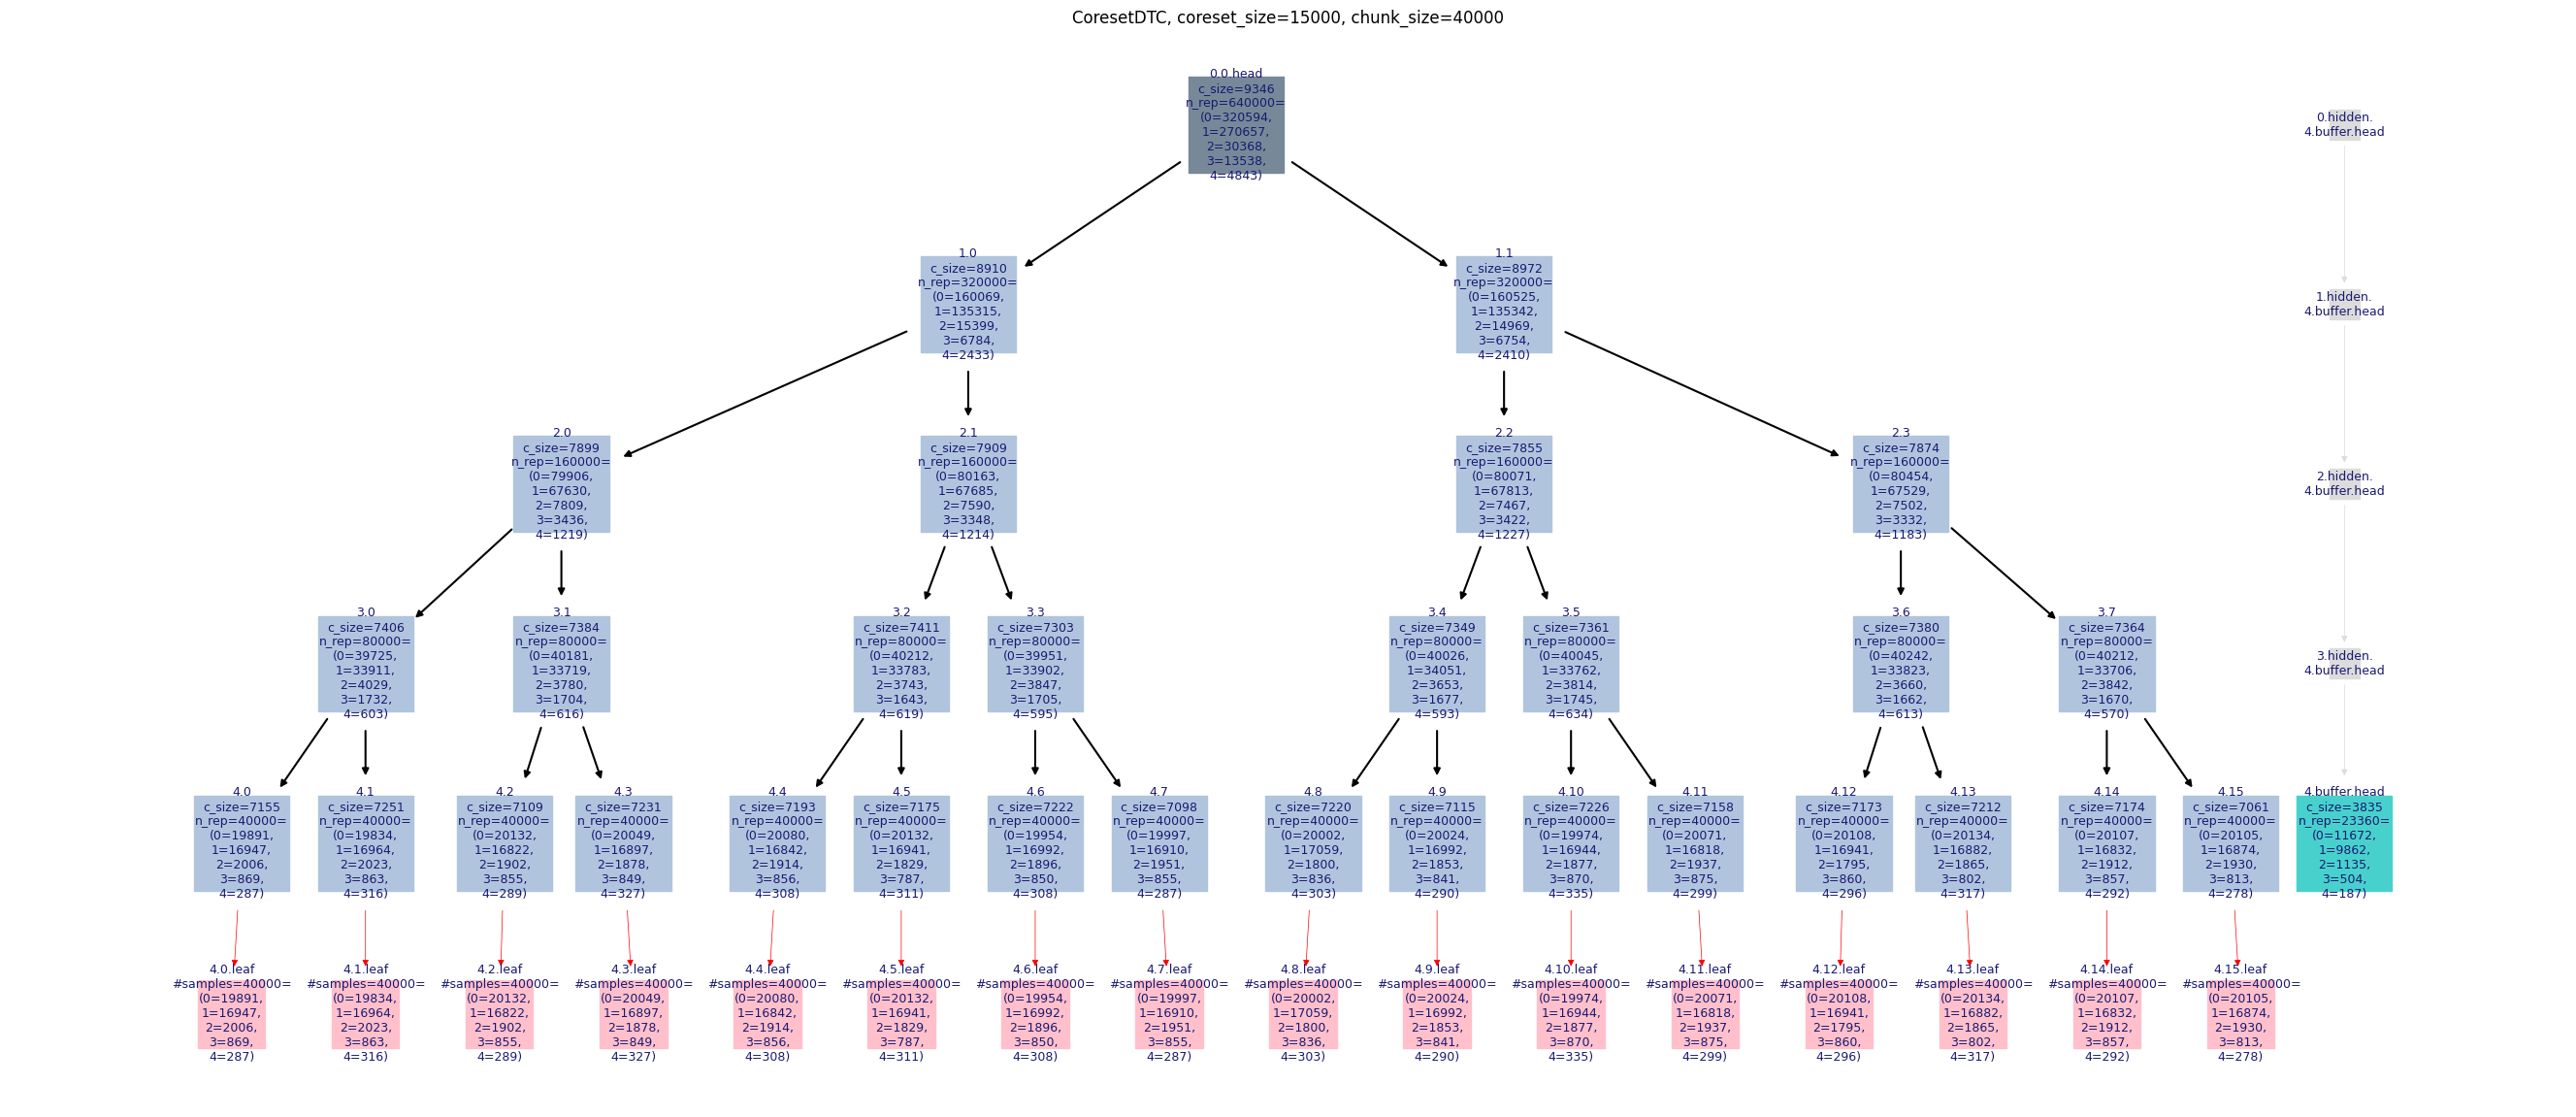

In [21]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
service_obj.plot(output_dir, "train_tree")

### 6.4. Save coreset for future use

In [22]:
final_coreset_path = os.path.join(output_dir, "final_coreset")
service_obj.save_coreset(final_coreset_path)